Download the data set. Only do this the first time.

In [ ]:

#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
file_id = '1OJeaPZQ81govaKk8M9J3MsCAoVGz4wJ8'
destination = 'Data.zip'
download_file_from_google_drive(file_id, destination)

In [2]:
!ls

sample_data


In [ ]:
!unzip Data.zip >/dev/null

Display image in IPython

In [5]:
!ls MURA-v1.1/

train		       train_labeled_studies.csv  valid_image_paths.csv
train_image_paths.csv  valid			  valid_labeled_studies.csv


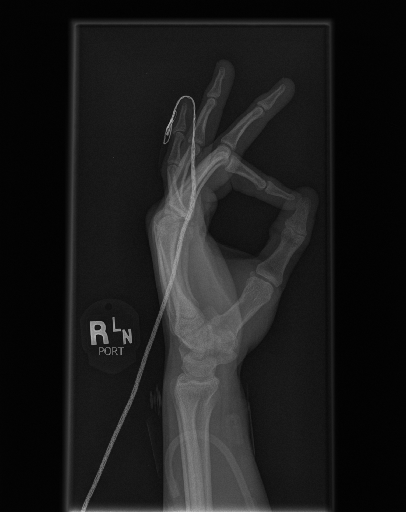

In [6]:
from IPython.display import display, Image

path = "MURA-v1.1/valid/XR_HAND/patient11599/study1_negative/image1.png"

img = Image(path)
display(img)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dropout, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
import pandas as pd

In [ ]:
def make_model(batch_size=None):
  model = Sequential()
  
  model.add(Conv2D(64, (7, 7), strides=(2, 2), input_shape=(227,227,1)))
  model.add(Activation("relu"))
  
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  
  model.add(Conv2D(128, (5, 5), strides=(2, 2)))
  model.add(Activation("relu"))
  
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  
  model.add(Conv2D(256, (3, 3), strides=(1, 1)))
  model.add(Activation("relu"))
  
  model.add(Conv2D(384, (3, 3), strides=(1, 1)))
  model.add(Activation("relu"))
  
  model.add(Conv2D(256, (3, 3), strides=(1, 1)))
  model.add(Activation("relu"))
  
  model.add(Conv2D(256, (3, 3), strides=(1, 1)))
  model.add(Activation("relu"))
  
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(2048))
  model.add(Activation("relu"))
  
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  model.add(Activation("sigmoid"))


  model.compile(loss='binary_crossentropy',
                optimizer= tf.train.AdamOptimizer(learning_rate=0.001),
                metrics=['accuracy'])

  return model
   

In [ ]:
import os

def get_data(path):
  files = []
  for r, d, f in os.walk(path):
      for file in f:
          if '.png' in file:
            filePath = os.path.join(r, file)
            files.append((filePath, str('positive' in filePath)))
  return files

train_data = get_data('./MURA-v1.1/train/')
valid_data = get_data('./MURA-v1.1/valid/')

In [ ]:
batch_size= 64*8

tl = len(train_data) - 1
vl = len(valid_data) - 1
train_data = train_data[:tl*batch_size]
valid_data = valid_data[:vl*batch_size]


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame(train_data, columns=["path", "label"]),
    x_col="path",
    y_col="label",
    directory=None,
    target_size=(227, 227),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="binary"
)


valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame(valid_data, columns=["path", "label"]),
    x_col="path",
    y_col="label",
    directory=None,
    target_size=(227, 227),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="binary"
)

tf.keras.backend.clear_session()
model = make_model(batch_size)
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

tpu_model.summary()

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
tpu_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=3
)

Found 36808 images belonging to 2 classes.
Found 3197 images belonging to 2 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.126.179.186:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13607001780914680259)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_

In [ ]:
tf.keras.backend.clear_session()
training_model = make_model(batch_size = 128)
training_model.summary()